In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from joblib import Parallel, delayed
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import RandomOverSampler

In [3]:
RDN = 42
N_CLASSES = 2
BATCH_SIZE = 4
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001

# Processamento dos dados

In [4]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 

  0%|          | 0/153 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:03<00:00, 17.56it/s]


In [5]:
for i in range(len(control_data)):
    df = control_data[i]
    replace_dict = {
        column: column.replace('shen-268', 'Shen_268').replace('Shen-268', 'Shen_268')
        for column in df.columns
    }
    control_data[i] = df.rename(columns=replace_dict)

In [6]:
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

In [7]:
parkinson_correlation_matrix = parkinson.utils.correlation.ledoit_wolf_correlation(parkinson_atlas_data, return_upper_triangular=False)
control_correlation_matrix = parkinson.utils.correlation.ledoit_wolf_correlation(control_atlas_data, return_upper_triangular=False)

In [8]:
def get_sparse_adjacency_matrix(correlation_matrix: np.array, threshold: float = 0.01):
    a = correlation_matrix.copy()
    N = len(a)
    a[np.abs(a) < threshold] = 0
    a[np.abs(a) > threshold] = 1
    a -= np.eye(N)
    return sp.sparse.csr_matrix(a)

In [9]:
correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

In [10]:
connectivity_graphs = [
    get_sparse_adjacency_matrix(matrix, threshold=0.2) for matrix in correlation_matrices
]

In [11]:
graph_laplacians = [
    sp.sparse.csgraph.laplacian(matrix, normed=True)
    for matrix in connectivity_graphs
]

In [12]:
graph_connectivity = [
    sp.sparse.linalg.eigs(laplacian, which='SR', k=10)[0][1:10].real
    for laplacian in tqdm(graph_laplacians)
]

100%|██████████| 219/219 [00:04<00:00, 47.90it/s]


<Axes: >

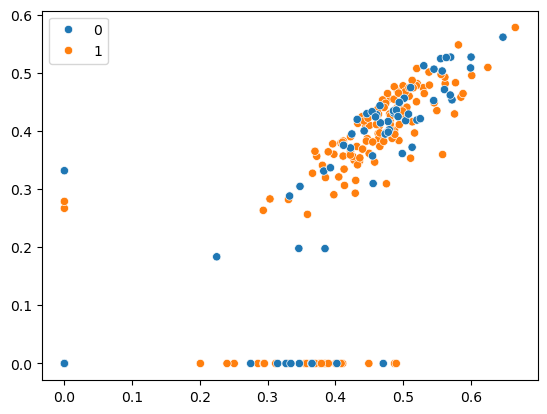

In [13]:
sns.scatterplot(
    x=np.array(graph_connectivity)[:, 1],
    y=np.array(graph_connectivity)[:, 0],
    hue=y
)

In [14]:
# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(graph_connectivity, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)

In [15]:
classifier = SVC(class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
classifier.predict(X_test)

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.31      0.31        13
           1       0.71      0.71      0.71        31

    accuracy                           0.59        44
   macro avg       0.51      0.51      0.51        44
weighted avg       0.59      0.59      0.59        44



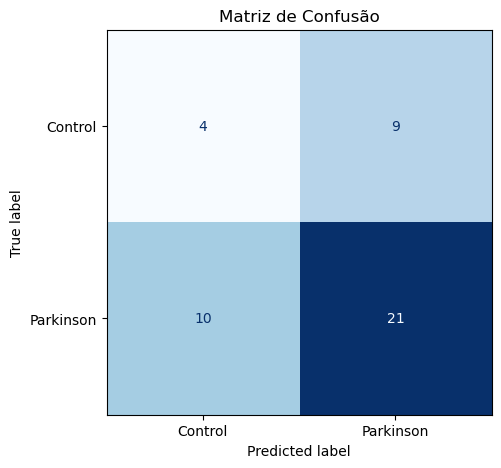

In [646]:
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(y_pred, y_test, class_names=['Control','Parkinson'])

Teste com as possibilidades possiveis

In [ ]:
from parkinson.utils.correlation import (
    graphical_lasso_correlation,
    ledoit_wolf_correlation,
    pearson_correlation,
    sliding_window_correlation
)

correlation_methods_list = [
    ('ledoit', ledoit_wolf_correlation),
    ('pearson', pearson_correlation),
    ('sliding', sliding_window_correlation)
]

results_dict = {}

for atlas in tqdm(['atlas', 'AAL3']):
    results_dict[atlas] = {}
    control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, atlas)
    parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, atlas)
    for method_name, method_function in tqdm(correlation_methods_list, leave=False):
        results_dict[atlas][method_name] = {}

        parkinson_correlation_matrix = method_function(parkinson_atlas_data, return_upper_triangular=False)
        control_correlation_matrix = method_function(control_atlas_data, return_upper_triangular=False)

        correlation_matrices = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
        y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
        correlation_matrices, y = parkinson.utils.data.filter_data(correlation_matrices, y)

        for threshold in tqdm(np.arange(0.04, 0.3, 0.01), leave=False):
            

            connectivity_graphs = [
                get_sparse_adjacency_matrix(matrix, threshold=threshold) 
                for matrix in correlation_matrices
            ]

            graph_laplacians = [
                sp.sparse.csgraph.laplacian(matrix, normed=True)
                for matrix in connectivity_graphs
            ]

            graph_connectivity = [
                sp.sparse.linalg.eigs(laplacian, which='SR', k=5)[0][1:6].real 
                for laplacian in graph_laplacians
            ]

            classifier = SVC(class_weight='balanced')
            score = np.mean(cross_val_score(classifier, X=graph_connectivity, y=y, cv=5))

            results_dict[atlas][method_name][threshold] = score

In [561]:
pd.DataFrame(results_dict['AAL3'])

,ledoit,pearson,sliding
0.04,0.543446,0.433615,0.575899
0.05,0.543129,0.520719,0.589641
0.06,0.538689,0.589112,0.584989
0.07,0.570930,0.534567,0.561628
0.08,0.584778,0.520190,0.515539
0.09,0.580127,0.520507,0.552643
0.10,0.575581,0.525370,0.534461
0.11,0.557294,0.570825,0.530021
0.12,0.529915,0.589218,0.525581
0.13,0.529598,0.589112,0.502960


In [17]:
X_trainval, X_test, y_trainval, y_test = train_test_split(graph_connectivity, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

In [18]:
# Criando DataLoaders
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

/home/vitor/Documents/Parkinson-Diagnosis-Deeplearning/parkinson/utils/data.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_tensor = torch.tensor(X, dtype=torch.float32)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=len(X_train[0]), hidden_dim=4, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(
    model=model,
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR/100,
    path="../weights/4_laplacian"
)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

train-loss: 0.8768  train-acc: 0.3053 | val-loss: 0.8769  val-acc: 0.2955:  10%|█         | 20/200 [00:08<01:16,  2.37it/s]

Early stopping at epoch 21


In [38]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)

/home/vitor/miniforge3/envs/parkinson/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Acurácia       F1  Precisão   Recall
 0.295455 0.134769  0.087293 0.295455


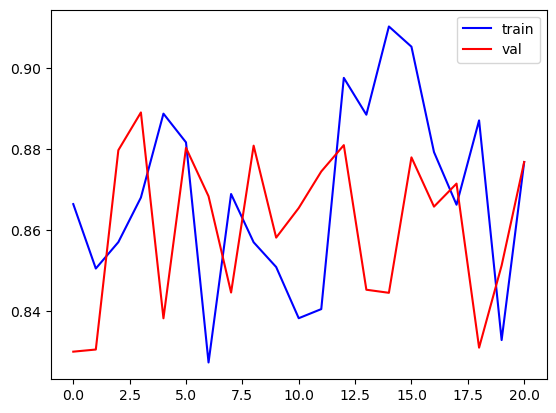

In [39]:
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])

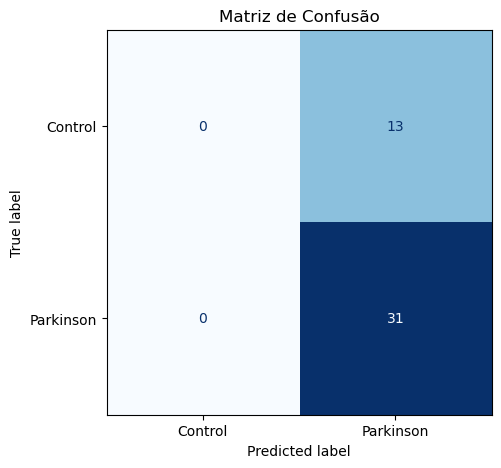

In [652]:
confusion_matrix = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])